In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../tools/')
import tools
import numpy as np

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.pipeline import make_pipeline

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
x_train = train.drop(['SalePrice', 'Id'],axis=1)
y_train = train.SalePrice
x_test = test.drop(['Id'],axis=1)

In [3]:
prc = tools.Process(x_train,x_test,y_train)
prc_init = tools.Process(x_train,x_test,y_train)

# Observation

## Focus on target variable

First, we create histgrams to see if the target variable is Normally distributed. \
If we want to create [any linear model, it is essential that the features are normally distributed]. \
This is one of the assumptions of multiple linear regression.  

[any linear model, it is essential that the features are normally distributed]:http://cogpsy.educ.kyoto-u.ac.jp/personal/Kusumi/datasem11/goto.pdf

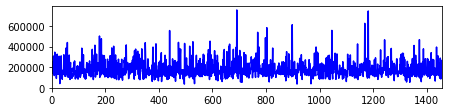

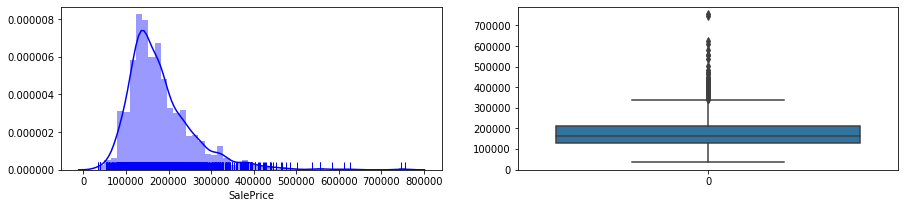

SalePrice has 0 NaNs (0.00%).
Skewness : 1.88
Kurtosis : 6.54
----------------------------------------------------------------------------------------------------------------------------------


In [4]:
prc.viewY()

These informations can tell us a lot about our target variable.
- Our target variable, **SalePrice** is not normally distributed.
- Our taget variable is right-skewed.
- There are multiple outliers in the variable.

Next, find out the relationships among the target variable and other predictor variables.

In [5]:
corrs = prc.CorrY(view_set_top=10,bar=False, get_return=True)

                |corr|
Features              
OverallQual   0.790982
GrLivArea     0.708624
GarageCars    0.640409
GarageArea    0.623431
TotalBsmtSF   0.613581
1stFlrSF      0.605852
FullBath      0.560664
TotRmsAbvGrd  0.533723
YearBuilt     0.522897
YearRemodAdd  0.507101


The most correlated variable is **OverallQual**. \
Let's put top variables in a scatter plot and see how them look.

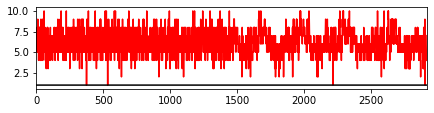

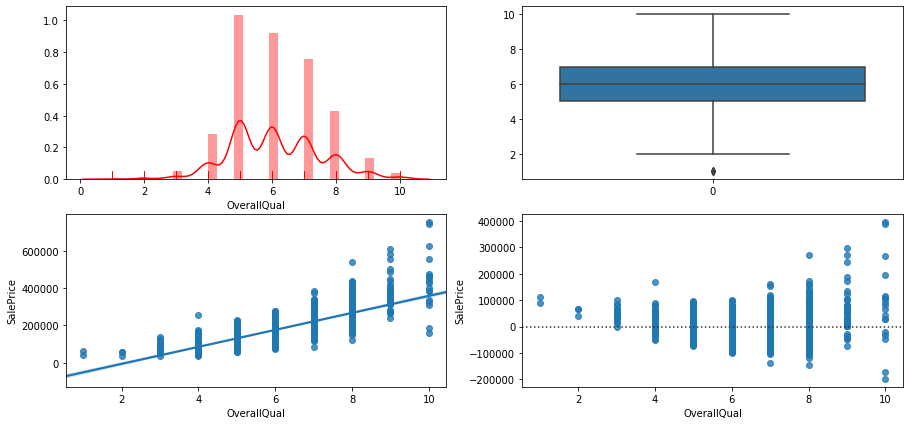

OverallQual has 0 NaNs (0.00%).
Correlation Coefficient (OverallQual vs SalePrice): 0.791
Skewness : 0.20
Kurtosis : 0.07
Number of anomaly scores over threshold(1.0%) : 17 / 2919
Border line :  1.0
----------------------------------------------------------------------------------------------------------------------------------


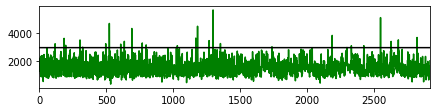

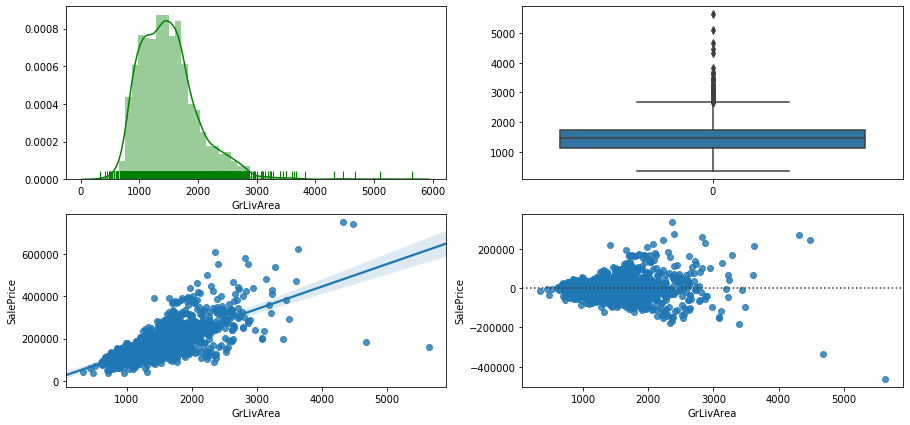

GrLivArea has 0 NaNs (0.00%).
Correlation Coefficient (GrLivArea vs SalePrice): 0.709
Skewness : 1.27
Kurtosis : 4.12
Number of anomaly scores over threshold(1.0%) : 30 / 2919
Border line :  2944.0
----------------------------------------------------------------------------------------------------------------------------------


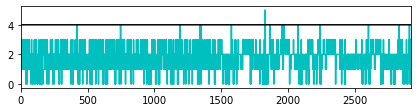

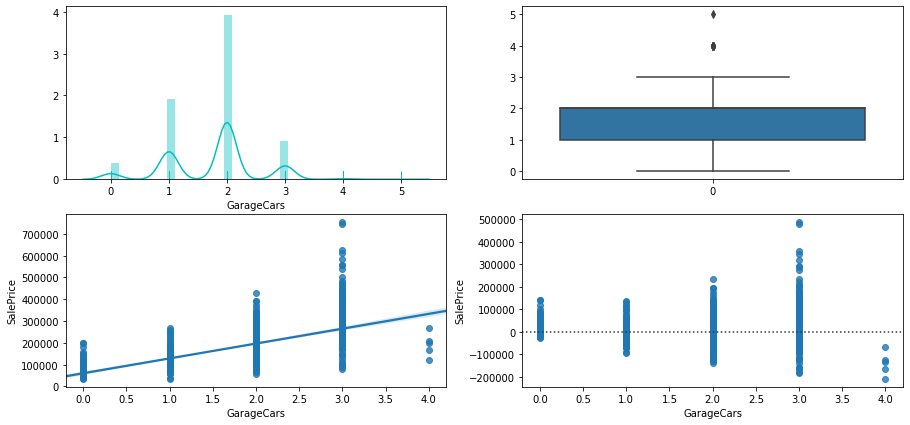

GarageCars has 1 NaNs (0.03%).
Correlation Coefficient (GarageCars vs SalePrice): 0.640
Skewness : -0.22
Kurtosis : 0.24
Number of anomaly scores over threshold(1.0%) : 17 / 2919
Border line :  4.0
----------------------------------------------------------------------------------------------------------------------------------


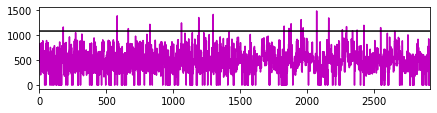

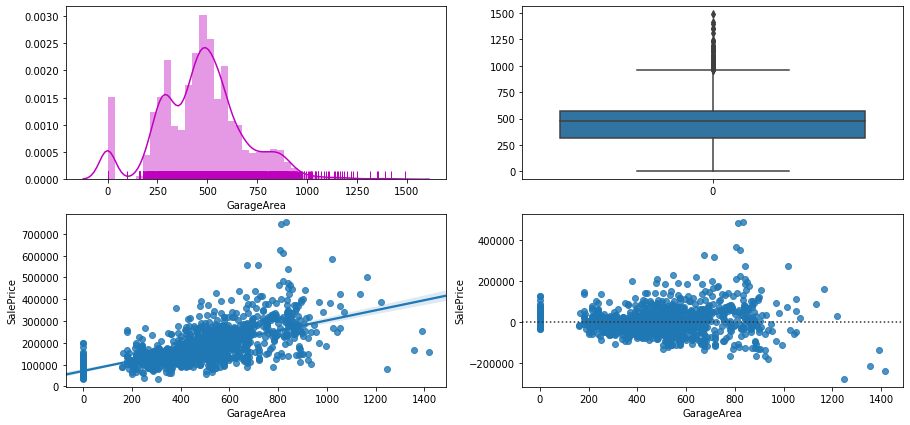

GarageArea has 1 NaNs (0.03%).
Correlation Coefficient (GarageArea vs SalePrice): 0.623
Skewness : 0.24
Kurtosis : 0.94
Number of anomaly scores over threshold(1.0%) : 21 / 2919
Border line :  1085.0
----------------------------------------------------------------------------------------------------------------------------------


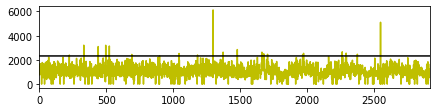

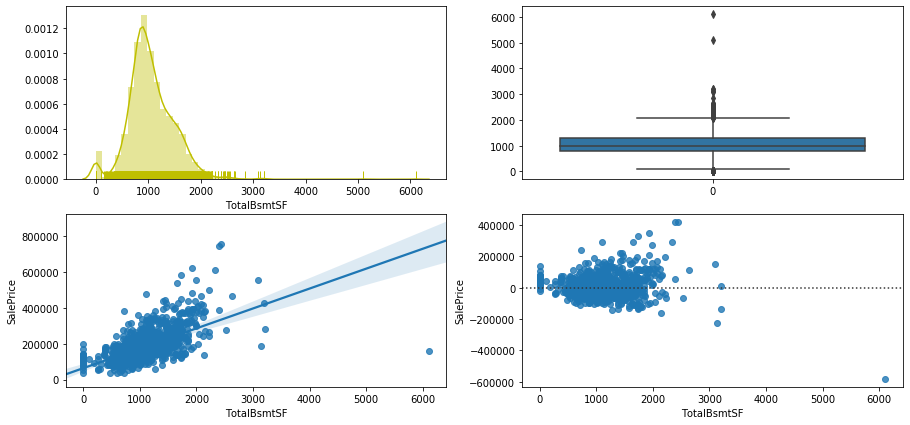

TotalBsmtSF has 1 NaNs (0.03%).
Correlation Coefficient (TotalBsmtSF vs SalePrice): 0.614
Skewness : 1.16
Kurtosis : 9.15
Number of anomaly scores over threshold(1.0%) : 23 / 2919
Border line :  2320.0
----------------------------------------------------------------------------------------------------------------------------------


In [6]:
prc.CorrY(view_set=False,bar=False,plot=True, input_cols=corrs.index[:5])

Let's check out some high correlated features to determine the outliers.
- **SalePrice vs OverallQual** \
Clearly, OverallQual is a categorical variable and scatter plot is not the best way to visualize categorical variables. \
However, it looks like <u>some of the houses are overpriced compared to their overall quality</u>.\
These could be outliers. 
- **SalePrice vs GrLivArea** \
As you can see <u>there are two outliers</u> in the plot above. \
We will get rid off them later.

**Observations**
- Our target variable shows an unequal level of variance across most predictor(independent) variable values.\
  This is called Heteroscedasticity (which is inverse of [Homoscedasticity]) and is a red flag for the multiple linear regression model.
- There are many outliers in the scatter plots above that took my attention.
- The two next to the top right edge of **SalePrice vs. GrLivArea** seems to follow a trend,\
  which can be explained by saying that <u>"As the area increased so did the prices"</u>.\
  However, The two on the bottom right of the same chart do not follow any trends.
  
[Homoscedasticity]:https://ja.wikipedia.org/wiki/%E7%AD%89%E5%88%86%E6%95%A3%E6%80%A7

##  Affinity with Multiple Linear Regression

### Assumptions of Regression

Before building a multiple linear regression model, we need to check that these assumptions below are valid.
- Linearity ( Correct functional form )
- Homoscedasticity ( Constant Error Variance )( vs Heteroscedasticity )
- Independence of Errors ( vs Autocorrelation ) 
- Multivariate Normality ( Normality of Errors ) 
- No or little [Multicollinearity]. 

[Multicollinearity]:http://jspt.japanpt.or.jp/ebpt_glossary/multicollinearity.html

Since we fit a **linear** model, we assume that the relationship is linear and the errors, or residuals, are pure random fluctuations around the true line. \
We assume that the variability in the response(dependent) variable doesn't increase as the value of the predictor(independent) increases, \
which is the assumptions of equal variance, also known as **Homoscedasticity**. \
We also assume that the observations are independent of one another(**No Multicollinearity**) \
and a correlation between sequential observations or [auto-correlation] are not there.

Now, these assumptions are prone to happen altogether. In other words, \
<u>if we see one of these assumptions in the dataset, it's more likely that we may come across with one of the different assumptions</u>. 

So, How do we check regression assumptions? \
We fit a regression line and look for the variability of the response data along the regression line.\
Let's apply this for each one of them.

[auto-correlation]:https://bellcurve.jp/statistics/course/12935.html

### Linearity

**Linearity** ( Correct functional form ) Linear regression needs the relationship between each independent variable\
and the dependent variable to be linear. \
The linearity assumption can be tested with scatter plots. \
The following two examples depict two cases, where no or little linearity is present.

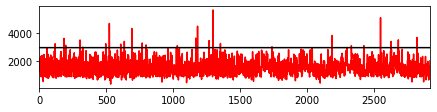

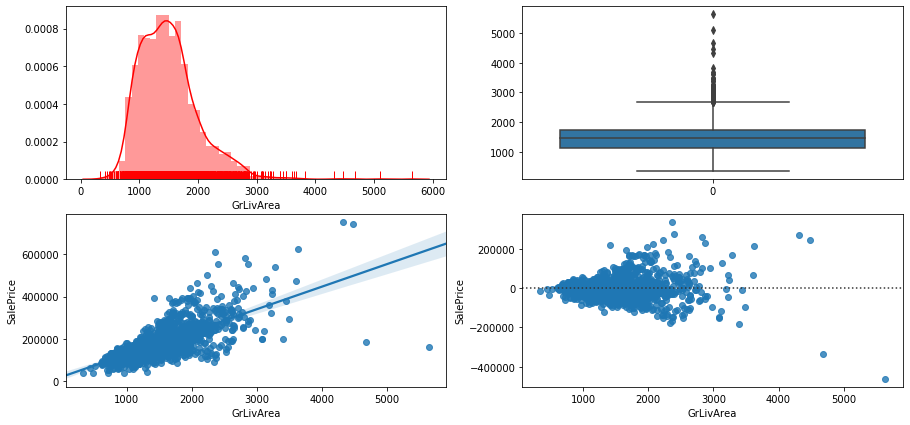

GrLivArea has 0 NaNs (0.00%).
Correlation Coefficient (GrLivArea vs SalePrice): 0.709
Skewness : 1.27
Kurtosis : 4.12
Number of anomaly scores over threshold(1.0%) : 30 / 2919
Border line :  2944.0
----------------------------------------------------------------------------------------------------------------------------------


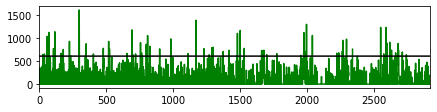

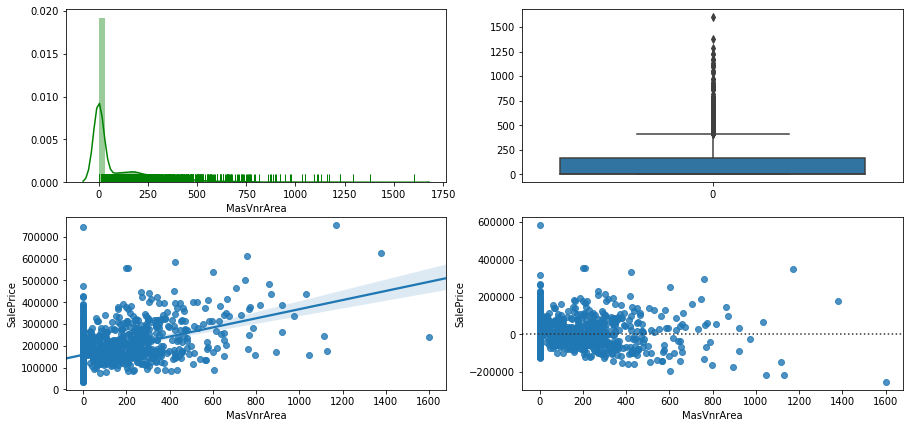

MasVnrArea has 23 NaNs (0.79%).
Correlation Coefficient (MasVnrArea vs SalePrice): 0.477
Skewness : 2.60
Kurtosis : 9.25
Number of anomaly scores over threshold(1.0%) : 72 / 2919
Border line :  604.0
----------------------------------------------------------------------------------------------------------------------------------


In [7]:
prc.viewF(input_cols=['GrLivArea', 'MasVnrArea'])

It's pretty apparent from the chart that there is a better linear relationship between **SalePrice and GrLivArea** than **SalePrice and MasVnrArea**.\
One thing to take note here, <u>there are some outliers in the dataset</u>. \
It is imperative to check for outliers since <u>linear regression is sensitive to outlier effects</u>. \
Sometimes we may be trying to fit a linear regression model when the data might not be so linear,or the function may need another degree of freedom to fit the data. \
In that case, we may need to change our function depending on the data to get the best possible fit. 

Ideally, if the assumptions are met, the residuals will be randomly scattered around the centerline of zero with no apparent pattern. \
However, our residual plot is **anything but an unstructured cloud of points**.\
Even though it seems like there is a linear relationship between the response variable and predictor variable,
<u>the error plot shows that as **GrLivArea value** increases the variance also increases</u>, \
which is the characteristics known as **Heteroscedasticity**.

Now, let's make sure that the target variable follows a normal distribution.

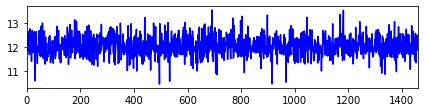

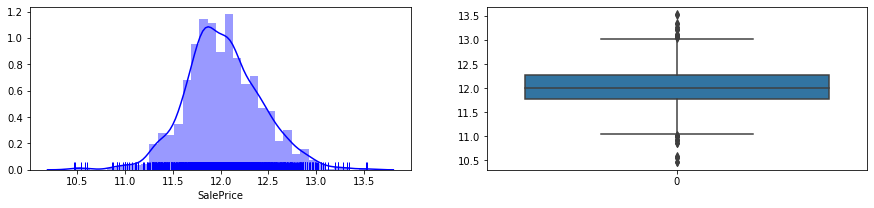

SalePrice has 0 NaNs (0.00%).
Skewness : 0.12
Kurtosis : 0.81
----------------------------------------------------------------------------------------------------------------------------------


In [8]:
_1, _2,y_train_transed = prc.transY(method='log', inplace=False, get_return=True)
prc_tmp = tools.Process(_1,_2,y_train_transed)
prc_tmp.viewY()

As you can see the log transformation removes the normality of errors.\
This solves some of the other assumptions that we talked about above like Homoscedasticity. \
Let's make a comparison of the pre-transformed and post-transformed state of residual plots.

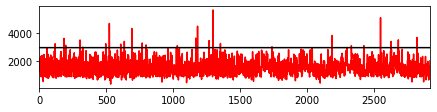

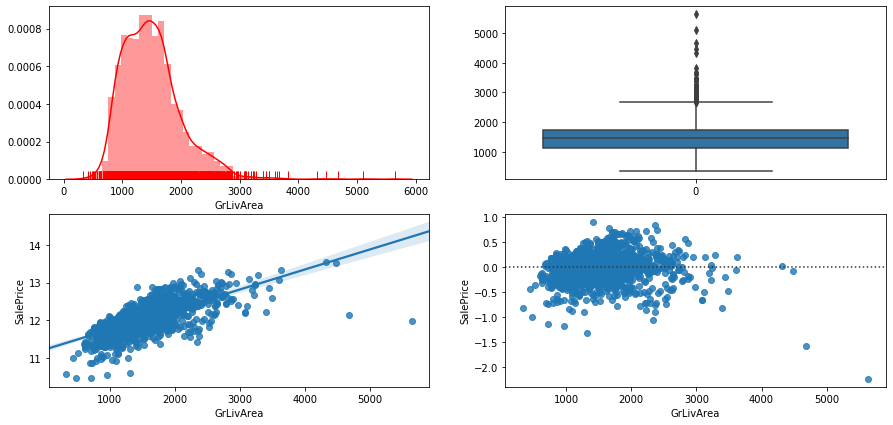

GrLivArea has 0 NaNs (0.00%).
Correlation Coefficient (GrLivArea vs SalePrice): 0.701
Skewness : 1.27
Kurtosis : 4.12
Number of anomaly scores over threshold(1.0%) : 30 / 2919
Border line :  2944.0
----------------------------------------------------------------------------------------------------------------------------------


In [9]:
prc_tmp.viewF(input_cols=['GrLivArea'])

Here, we can see that the post-transformed chart has almost an equal amount of variance across the zero lines.

### Multicollinearity

**No or Little multicollinearity**:\
Multicollinearity is when there is a strong correlation between independent variables. \
Linear regression or multilinear regression requires independent variables to have little or no similar features. \
Multicollinearity can lead to a variety of problems, including:
- The effect of predictor variables estimated by our regression will depend on what other variables are included in our model. 
- Predictors can have wildly different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects. 
- With very high multicollinearity, the inverse matrix, the computer calculates may not be accurate. 
- We can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant.\
The reason behind that is, when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

Heatmap is an excellent way to identify whether there is multicollinearity or not. \
The best way to solve multicollinearity is to use regularization methods like Ridge or Lasso.

             var1          var2    |corr|
0      GarageArea    GarageCars  0.889700
1     GarageYrBlt     YearBuilt  0.834812
2    TotRmsAbvGrd     GrLivArea  0.808354
3        1stFlrSF   TotalBsmtSF  0.801670
4    TotRmsAbvGrd  BedroomAbvGr  0.669737
..            ...           ...       ...
624  LowQualFinSF       LotArea  0.000554
625  KitchenAbvGr  LowQualFinSF  0.000438
626      2ndFlrSF     BsmtUnfSF  0.000376
627       MiscVal  BedroomAbvGr  0.000245
628        YrSold    WoodDeckSF  0.000180

[629 rows x 3 columns]


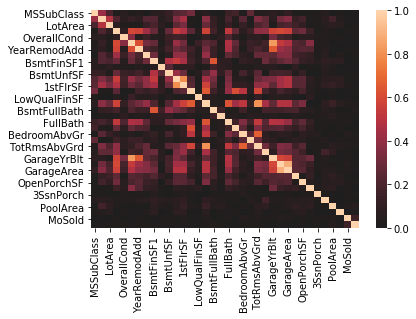

In [10]:
prc.CorrF(view_set_top=-1, view_map=True)

As we can see, the multicollinearity still exists in various features. \
However, we will keep them for now for the sake of learning and lets models(e.x. Regularization models such as Lasso, Ridge) do the clean up later on.

If I were using only multiple linear regression, I would be deleting these features from the dataset to fit better multiple linear regression algorithms.\
However, we will be using many algorithms as scikit learn modules makes it easy to implement them and get the best possible model.\
Therefore, we will keep all the features for now.

# Feature Engineering

## Reject outliers

In [12]:
save_index = prc.x_train[prc.x_train.GrLivArea < 4500].index.to_list()
prc.x_train = prc.x_train.loc[save_index]
prc.x_train.reset_index(drop = True, inplace = True)
prc.y_train = prc.y_train.loc[save_index]
prc.y_train.reset_index(drop = True, inplace = True)
prc.update()

## Dealing with Missing Values

### Missing data in all data

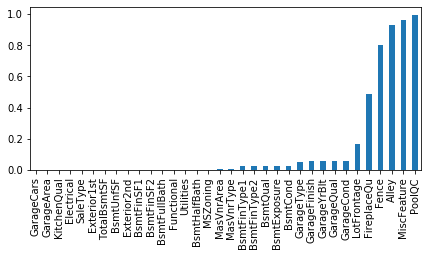

34

In [13]:
col_nans = prc_init.NANs(top=-1,bar=True,get_return=True)
len(col_nans)

### Imputing Missing Values

In [14]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = [
                    "Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']
for i in missing_val_col:
    prc.x_all[i] = prc.x_all[i].fillna('None')
    
## These features are continous variable, we used "0" to replace the null values. 
missing_val_col2 = [
                    'BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']
for i in missing_val_col2:
    prc.x_all[i] = prc.x_all[i].fillna(0)
    
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
prc.x_all['LotFrontage'] = prc.x_all.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

## Zoning class are given in numerical; therefore converted to categorical variables. 
prc.x_all['MSSubClass'] = prc.x_all['MSSubClass'].astype(str)
prc.x_all['MSZoning'] = prc.x_all.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Important years and months that should be categorical variables not numerical. 
prc.x_all['YrSold'] = prc.x_all['YrSold'].astype(str)
prc.x_all['MoSold'] = prc.x_all['MoSold'].astype(str) 

prc.x_all['Functional'] = prc.x_all['Functional'].fillna(prc.x_all['Functional'].mode()[0]) 
prc.x_all['Utilities'] = prc.x_all['Utilities'].fillna(prc.x_all['Utilities'].mode()[0]) 
prc.x_all['Exterior1st'] = prc.x_all['Exterior1st'].fillna(prc.x_all['Exterior1st'].mode()[0]) 
prc.x_all['Exterior2nd'] = prc.x_all['Exterior2nd'].fillna(prc.x_all['Exterior2nd'].mode()[0])
prc.x_all['KitchenQual'] = prc.x_all['KitchenQual'].fillna(prc.x_all['KitchenQual'].mode()[0]) 
prc.x_all['SaleType'] = prc.x_all['SaleType'].fillna(prc.x_all['SaleType'].mode()[0])
prc.x_all['Electrical'] = prc.x_all['Electrical'].fillna(prc.x_all['Electrical'].mode()[0]) 

In [15]:
prc.x_all.isnull().sum().any()

False

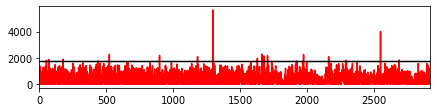

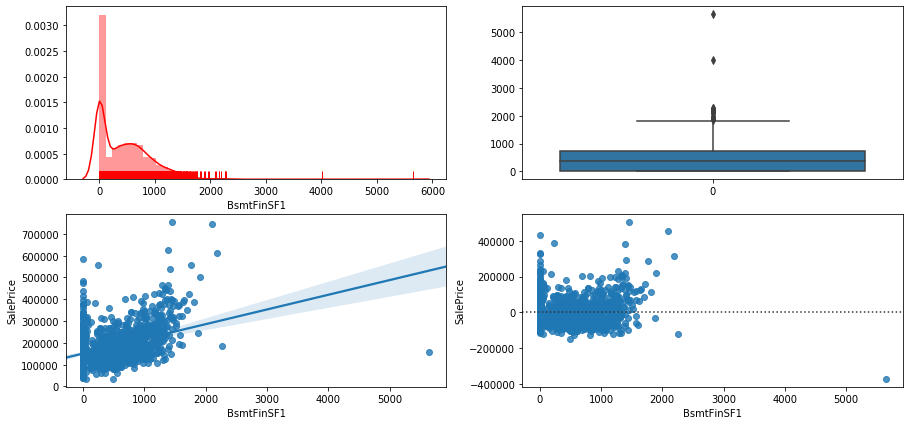

BsmtFinSF1 has 1 NaNs (0.03%).
Correlation Coefficient (BsmtFinSF1 vs SalePrice): 0.386
Skewness : 1.43
Kurtosis : 6.90
Number of anomaly scores over threshold(1.0%) : 23 / 2919
Border line :  1721.0
----------------------------------------------------------------------------------------------------------------------------------


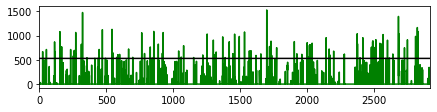

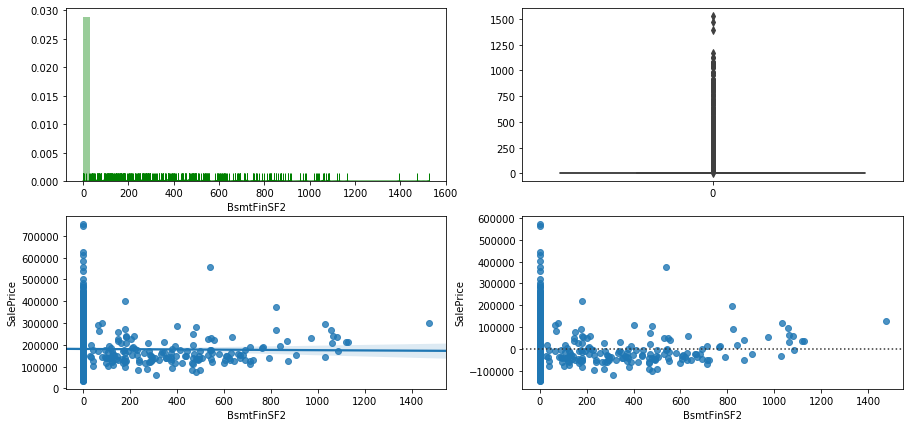

BsmtFinSF2 has 1 NaNs (0.03%).
Correlation Coefficient (BsmtFinSF2 vs SalePrice): -0.011
Skewness : 4.15
Kurtosis : 18.84
Number of anomaly scores over threshold(1.0%) : 107 / 2919
Border line :  529.0
----------------------------------------------------------------------------------------------------------------------------------


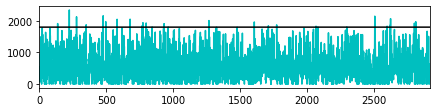

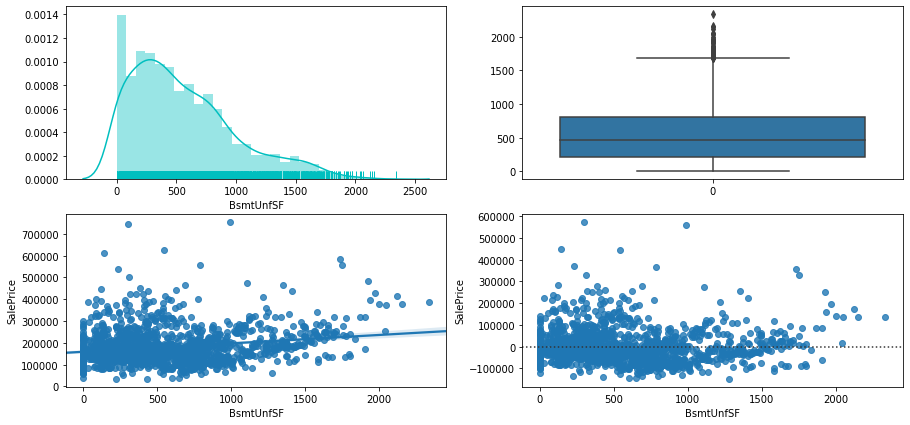

BsmtUnfSF has 1 NaNs (0.03%).
Correlation Coefficient (BsmtUnfSF vs SalePrice): 0.214
Skewness : 0.92
Kurtosis : 0.40
Number of anomaly scores over threshold(1.0%) : 28 / 2919
Border line :  1795.0
----------------------------------------------------------------------------------------------------------------------------------


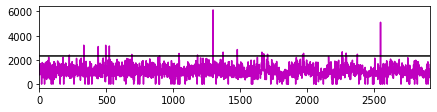

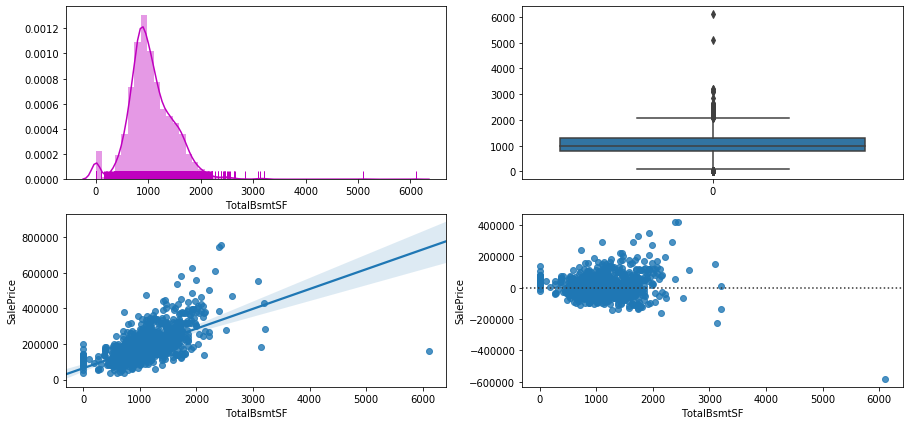

TotalBsmtSF has 1 NaNs (0.03%).
Correlation Coefficient (TotalBsmtSF vs SalePrice): 0.614
Skewness : 1.16
Kurtosis : 9.15
Number of anomaly scores over threshold(1.0%) : 23 / 2919
Border line :  2320.0
----------------------------------------------------------------------------------------------------------------------------------


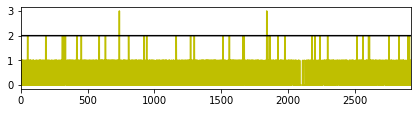

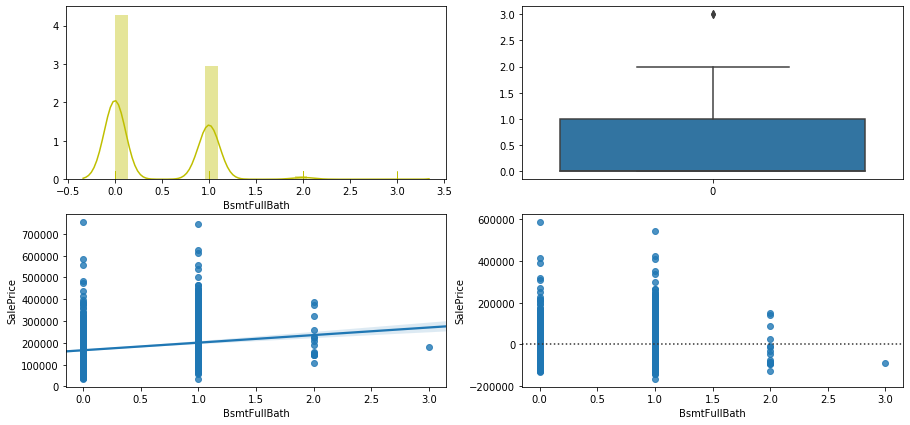

BsmtFullBath has 2 NaNs (0.07%).
Correlation Coefficient (BsmtFullBath vs SalePrice): 0.227
Skewness : 0.62
Kurtosis : -0.74
Number of anomaly scores over threshold(1.0%) : 40 / 2919
Border line :  2.0
----------------------------------------------------------------------------------------------------------------------------------


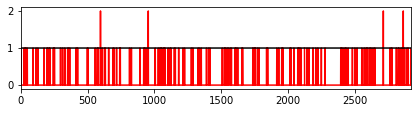

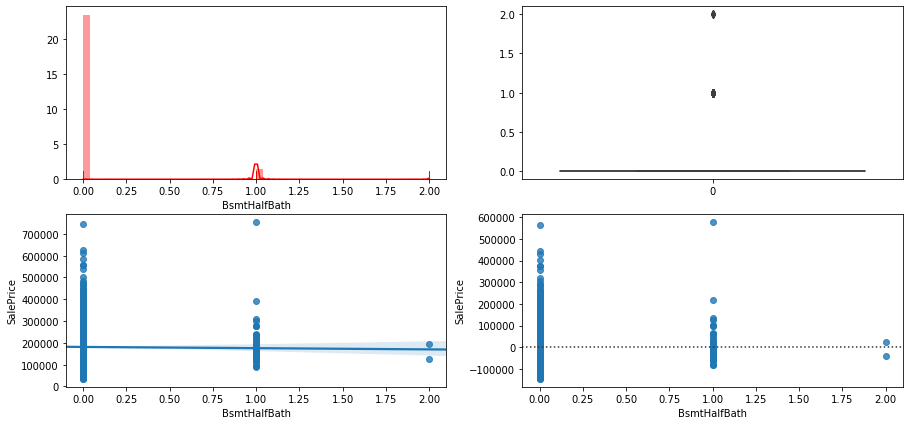

BsmtHalfBath has 2 NaNs (0.07%).
Correlation Coefficient (BsmtHalfBath vs SalePrice): -0.017
Skewness : 3.93
Kurtosis : 14.85
Number of anomaly scores over threshold(1.0%) : 175 / 2919
Border line :  1.0
----------------------------------------------------------------------------------------------------------------------------------


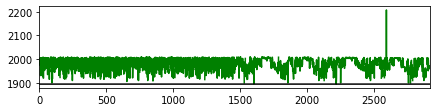

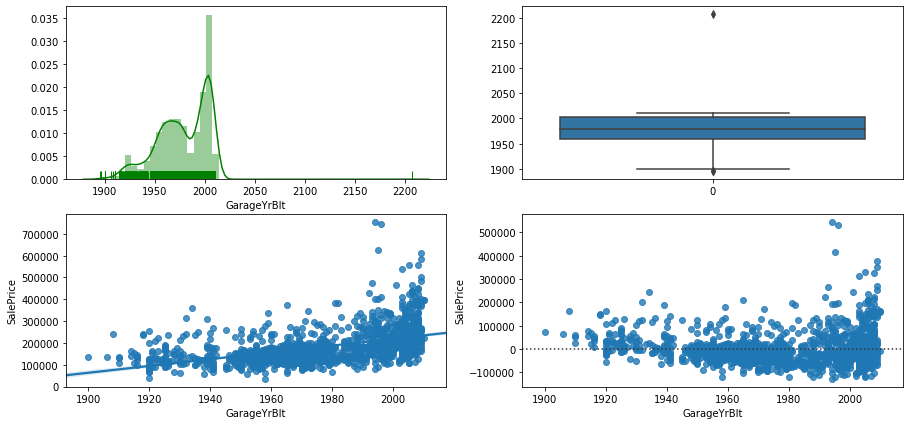

GarageYrBlt has 159 NaNs (5.45%).
Correlation Coefficient (GarageYrBlt vs SalePrice): 0.486
Skewness : -0.38
Kurtosis : 1.81
Number of anomaly scores over threshold(1.0%) : 11 / 2919
Border line :  1895.0
----------------------------------------------------------------------------------------------------------------------------------


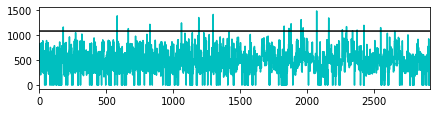

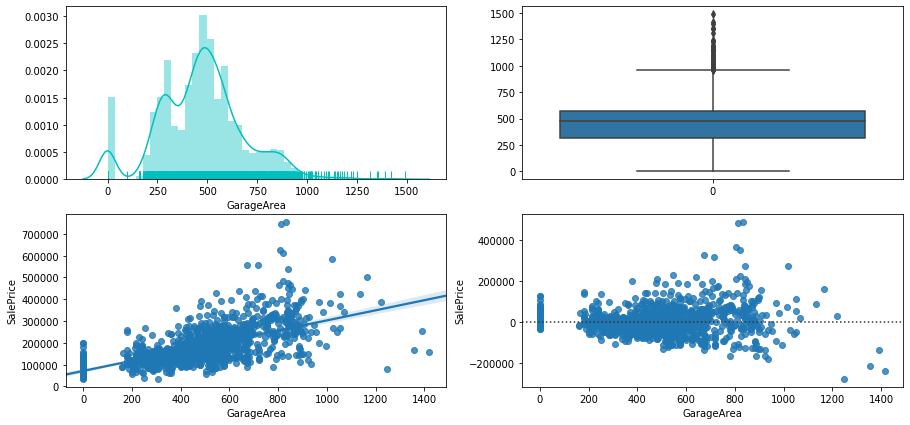

GarageArea has 1 NaNs (0.03%).
Correlation Coefficient (GarageArea vs SalePrice): 0.623
Skewness : 0.24
Kurtosis : 0.94
Number of anomaly scores over threshold(1.0%) : 21 / 2919
Border line :  1085.0
----------------------------------------------------------------------------------------------------------------------------------


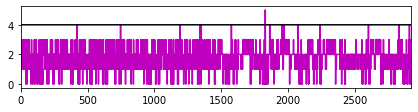

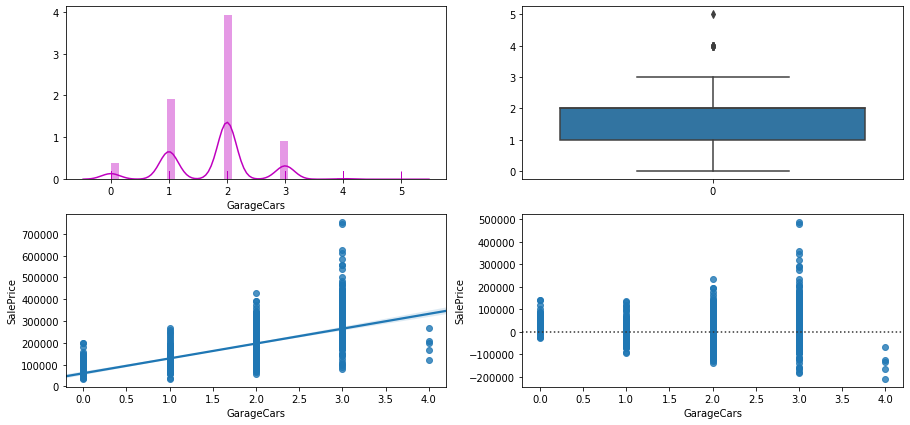

GarageCars has 1 NaNs (0.03%).
Correlation Coefficient (GarageCars vs SalePrice): 0.640
Skewness : -0.22
Kurtosis : 0.24
Number of anomaly scores over threshold(1.0%) : 17 / 2919
Border line :  4.0
----------------------------------------------------------------------------------------------------------------------------------


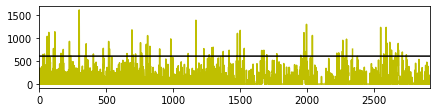

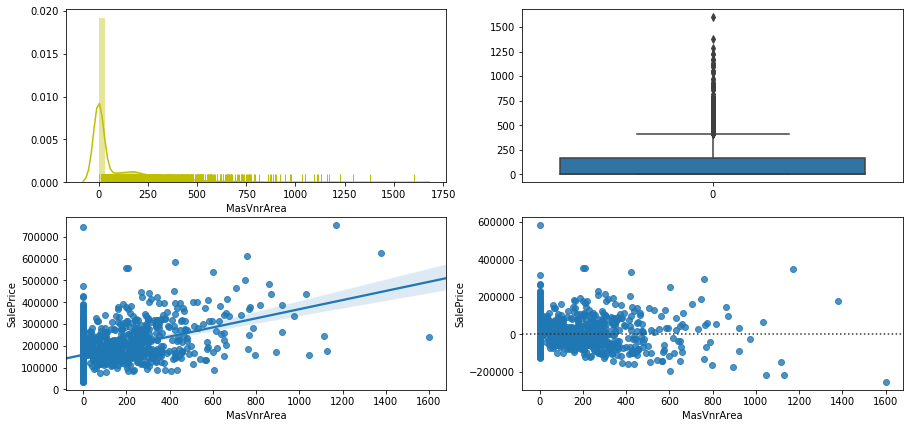

MasVnrArea has 23 NaNs (0.79%).
Correlation Coefficient (MasVnrArea vs SalePrice): 0.477
Skewness : 2.60
Kurtosis : 9.25
Number of anomaly scores over threshold(1.0%) : 72 / 2919
Border line :  604.0
----------------------------------------------------------------------------------------------------------------------------------


In [16]:
prc_init.viewF(input_cols=[
                    'BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea'])

## Dealing with Skewed Features

In [17]:
prc.Skews(bar=False, get_return=True)

MiscVal          21.950962
PoolArea         17.697766
LotArea          13.116240
LowQualFinSF     12.090757
3SsnPorch        11.377932
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
EnclosedPorch     4.004404
ScreenPorch       3.947131
BsmtHalfBath      3.932018
dtype: float64

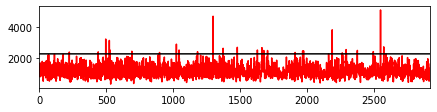

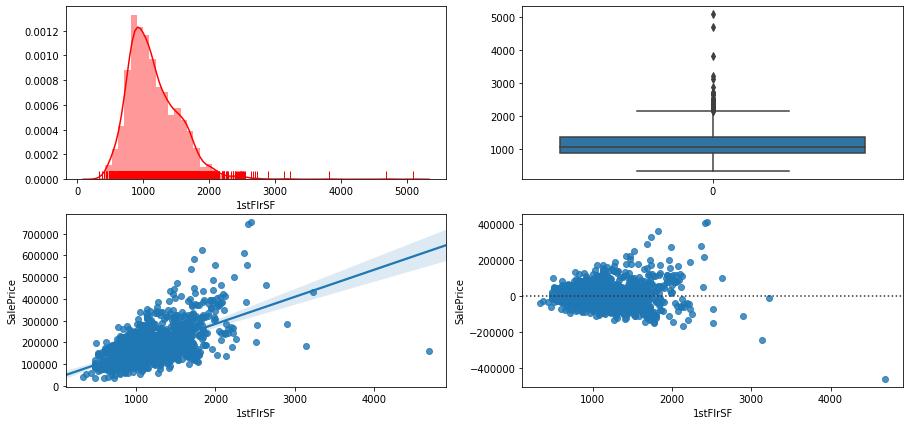

1stFlrSF has 0 NaNs (0.00%).
Correlation Coefficient (1stFlrSF vs SalePrice): 0.606
Skewness : 1.47
Kurtosis : 6.96
Number of anomaly scores over threshold(1.0%) : 32 / 2919
Border line :  2276.0
----------------------------------------------------------------------------------------------------------------------------------


In [18]:
prc_init.viewF(input_cols=['1stFlrSF'])

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


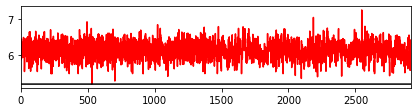

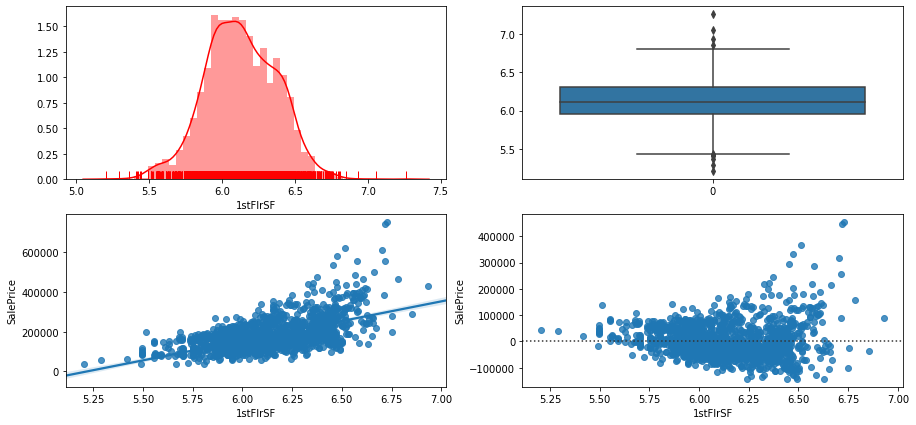

1stFlrSF has 0 NaNs (0.00%).
Correlation Coefficient (1stFlrSF vs SalePrice): 0.597
Skewness : -0.01
Kurtosis : 0.04
Number of anomaly scores over threshold(1.0%) : 11 / 2917
Border line :  5.203415808980815
----------------------------------------------------------------------------------------------------------------------------------


In [19]:
prc.transF(threshold=0.5, method='boxcox', inplace=True, get_return=False)
prc.viewF(input_cols=['1stFlrSF'])

## Drop Features

In [20]:
prc.x_all = prc.x_all.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

## Make new Features

### Make Features about SF

In [21]:
prc.x_all['TotalSF'] = prc.x_all['TotalBsmtSF'] + prc.x_all['1stFlrSF'] + prc.x_all['2ndFlrSF']
prc.x_all['YrBltAndRemod']=prc.x_all['YearBuilt']+prc.x_all['YearRemodAdd']
prc.x_all['Total_sqr_footage'] = (prc.x_all['BsmtFinSF1'] + prc.x_all['BsmtFinSF2'] +
                                 prc.x_all['1stFlrSF'] + prc.x_all['2ndFlrSF'])
prc.x_all['Total_Bathrooms'] = (prc.x_all['FullBath'] + (0.5 * prc.x_all['HalfBath']) +
                               prc.x_all['BsmtFullBath'] + (0.5 * prc.x_all['BsmtHalfBath']))
prc.x_all['Total_porch_sf'] = (prc.x_all['OpenPorchSF'] + prc.x_all['3SsnPorch'] +
                              prc.x_all['EnclosedPorch'] + prc.x_all['ScreenPorch'] +
                              prc.x_all['WoodDeckSF'])

In [22]:
prc.x_all['haspool'] = prc.x_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
prc.x_all['has2ndfloor'] = prc.x_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
prc.x_all['hasgarage'] = prc.x_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
prc.x_all['hasbsmt'] = prc.x_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
prc.x_all['hasfireplace'] = prc.x_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### Make Dummy Variables

In [25]:
prc.x_all.shape

(2917, 86)

In [24]:
final_features = pd.get_dummies(prc.x_all).reset_index(drop=True)
final_features.shape

(2917, 333)

### Option

In [84]:
X = final_features.iloc[:len(prc.y_train), :]
X_sub = final_features.iloc[len(prc.y_train):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = prc.y_train.drop(prc.y_train.index[outliers])

In [30]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

In [31]:
overfitted_features = overfit_reducer(X)
X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [82]:
X.shape, y.shape, X_sub.shape

((1458, 333), (1453,), (1459, 333))

# Fitting model (Advanced approach)

## Train-Test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((973, 332), (973,), (480, 332), (480,))

## Fitting models

In [49]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

In [62]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [41]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [47]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [52]:
lightgbm = LGBMRegressor(objective='regression', 
                                                   num_leaves=4,
                                                   learning_rate=0.01, 
                                                   n_estimators=5000,
                                                   max_bin=200, 
                                                   bagging_fraction=0.75,
                                                   bagging_freq=5, 
                                                   bagging_seed=7,
                                                   feature_fraction=0.2,
                                                   feature_fraction_seed=7,
                                                   verbose=-1)

In [53]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                             max_depth=3, min_child_weight=0,
                                             gamma=0, subsample=0.7,
                                             colsample_bytree=0.7,
                                             objective='reg:linear', nthread=-1,
                                             scale_pos_weight=1, seed=27,
                                             reg_alpha=0.00006)

In [54]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgboost, lightgbm),
                                                            meta_regressor=xgboost,
                                                            use_features_in_secondary=True)

## Cross Validation

In [58]:
score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge: 24048.5597 (3813.3785)



/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37139099827.904785, tolerance: 753589244.7009833
  tol, rng, random, positive)


KeyboardInterrupt: 

# References

- referenced kernel\
https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing
- normality of distribution\
http://cogpsy.educ.kyoto-u.ac.jp/personal/Kusumi/datasem11/goto.pdf
- Skewness and Kurtosis\
https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa  
https://toukeigaku-jouhou.info/2017/08/20/kurtosis/
- Homoscedasticity\
https://ja.wikipedia.org/wiki/%E7%AD%89%E5%88%86%E6%95%A3%E6%80%A7
- Multicollinearity\
http://jspt.japanpt.or.jp/ebpt_glossary/multicollinearity.html
- Auto Correlation\
https://bellcurve.jp/statistics/course/12935.html
- RobustScaler\
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html  
https://qiita.com/unhurried/items/7a79d2f3574fb1d0cc27
- sklearn models\
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html  
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html  
- StackingCVRegressor (mlxtend)\
https://anaconda.org/conda-forge/mlxtend  
http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/  